# Computer Vision Coursework Submission (IN3060/INM460)

**Student name, ID and cohort:** Anand Parekh (210038281) - PG


A copy of test_functions.ipynb was made in the 'Code' folder as the CW guidelines stated all implemented code needed to be in the 'Code' folder.

# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [17]:
# PLEASE ADD SHORTCUT of the CW_Folder_PG TO DRIVE
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [2]:
# PLEASE ADD SHORTCUT of the CW_Folder_PG TO DRIVE
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'CW_Dataset', 'Code', 'Models', 'Video', 'test_functions.ipynb']


### Load packages 

In the next cell you should load all the packages required to test your functions.

In [3]:
!pip install opencv-python==4.5.5.64
!pip install opencv-contrib-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 100 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 66.7 MB 13 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [4]:
!pip install skorch

     |████████████████████████████████| 155 kB 32.4 MB/s 


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
import time
import os
import cv2
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from skimage import img_as_ubyte, io, color
import pickle
from sklearn.neural_network import MLPClassifier
import torch
import torchvision
import torch.optim as optim
from skorch import NeuralNetClassifier
import torch.nn as nn
import torch.nn.functional as F
import random
from matplotlib import patches
from skimage.measure import label, regionprops


### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `EmotionRecognition` and `EmotionRecognitionVideo` to avoid having to reload them each time.

In [6]:
SVM = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','SVMFinal.joblib'))

In [7]:
Kmeans = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','Kmeans.joblib'))

In [8]:
MLP = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','MLPFinal.joblib'))

In [9]:
### Reference### 
###This CNN Code was adapted from Lab 08.ipynb of the Computer Vision Module at City, University of London
class Net(nn.Module):
    def __init__(self, units1 = 120, units2 = 84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(7744, units1)
        self.fc2 = nn.Linear(units1, units2)
        self.fc3 = nn.Linear(units2, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 7744)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [11]:
CNN = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNNFinal.pkl'))

# Test EmotionRecognition

This section should allow a quick test of the `EmotionRecognition` function. First, add cells with the code needed to load the necessary subroutines to make `EmotionRecognition` work.

1. Unzipping the Dataset.

In [12]:
### REFERENCE ###
# Code for unzipping the folder was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
Path_After = 'CW_Folder_PG/CW_Dataset' 
path = os.path.join('drive', 'My Drive', Path_After)
zip_path = os.path.join(path, 'CW_Dataset.zip')

!cp '{zip_path}' .

!yes|unzip -q CW_Dataset

!rm CW_Dataset.zip


2. Loading the test labels.

In [13]:
path_to_testlabels = 'CW_Dataset/labels/list_label_test.txt'

In [14]:
### REFERENCE ###
# I followed guide in the link to help me load labels: 
# https://riptutorial.com/tensorflow/example/27789/how-to-load-images-and-labels-from-a-txt-file

with open(path_to_testlabels) as f:
    testlabels = f.readlines()

labels = []
for target in testlabels:
  label = target[-2]
  labels.append(label)
# As mentioned in the full code file in the 'Code' folder, the last label doesn't get read. Therefore, I manually update the list with the correct label by looking at the files.
labels[-1] = '7'

 3. Defining my EmotionRecognition function. The
model_type can be:
- 'CNN'
- 'SIFTMLP'
- 'SIFTSVM'

In [18]:
def EmotionRecognition(path_to_test, model_type):
  start = time.time()
  path_to_testset= "CW_Dataset/test"
  # Writing a key to convert the integer labels to the corresponding emotions.
  key = {1:'Surprise', 2:'Fear', 3:'Disgust',4:'Happiness', 5:'Sadness', 6:'Anger', 7:'Neutral'}
  #Different key for CNN is used as CNN outputs values 0 to 6 inclusive
  keyCNN = {0:'Surprise', 1:'Fear', 2:'Disgust',3:'Happiness', 4:'Sadness', 5:'Anger', 6:'Neutral'}
  
 
### REFERENCE ###
  #This guide was used to write the code for generating random numbers: https://www.tutorialspoint.com/generating-random-number-list-in-python
  indexvalues = []
  for index in range(0,4):
    index = random.randint(0, len(os.listdir(path_to_testset)))
    indexvalues.append(index)


  #Reading 4 random images. Adding the corresponding labels to the y_test list and images to the test_image list
### REFERENCE ###
  #The code below for reading the images was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
  test_images = []
  y_test = []
  for index, testimage in enumerate(sorted(os.listdir(path_to_testset))):
    for j in indexvalues:  
      if index == j: # Accessing the images and labels with index numbers corresponding to the randomly generated numbers
        y_label = labels[j]
        y_test.append(y_label) # Adding the label to the y_test list
        if testimage.endswith(".jpg"):
            test_images.append(os.path.join(path_to_testset, testimage))
  x_test = [np.array(cv2.imread(testimage, 1)) for testimage in test_images]
  
  
  if model_type == 'CNN':
    
    x_testa = np.array(x_test, dtype=np.float32) #Processing the data to be compatible with the CNN

    CNNy_test = np.array(y_test,dtype=np.int64)-1 # Adjusting the y_test to be in range 0 to 6 inclusive

    x_testa = x_testa.reshape(4, 3, 100,100)
   
    y_testpred = CNN.predict(x_testa)  #Predicting the label of the test images using CNN
    y_testpreda = []
    # Creating a list of the emotions from the corresponding labels predicted eg. [Happiness, Suprised...] from [4, 1]
    for i in y_testpred:
      emotion = keyCNN[i]
      y_testpreda.append(emotion) # Adding the predicted emotion to the y_testpreda list
    y_testa = []

   # Creating a list of the True emotions from the corresponding true labels eg. [Happiness, Suprised...] from [4, 1]
    for i in CNNy_test:
      emotion = keyCNN[i]
      y_testa.append(emotion)

  ### REFERENCE ###
    #The code below for displaying the images and labels was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
    fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True, sharey=True)
    ax = axes.ravel()
    for i in range(4):
        ax[i].imshow(x_test[i])
        ax[i].set_title(f'Label: {y_testa[i]} \n Prediction: {y_testpreda[i]}')
        ax[i].set_axis_off()
    fig.tight_layout()
    plt.show()


  # Performing SIFT, Kmeans and creating histogram of code words
### REFERENCE ###
  # The SIFT, Kmeans and creating histogram of code words code below was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
  if model_type == 'SIFTMLP' or 'SIFTSVM':
    Hist = []

    for index in range(len(x_test)):
        sift = cv2.SIFT_create()
        image = img_as_ubyte(color.rgb2gray(x_test[index]))
        keypoint, descriptor = sift.detectAndCompute(image, None)

        if descriptor is not None:
          hist = np.zeros(70)

          idx = Kmeans.predict(descriptor)

          for j in idx:
              hist[j] = hist[j] + (1 / len(descriptor))

          Hist.append(hist)

        else:
          Hist.append(None)

    idx_not_empty = [index for index, value in enumerate(Hist) if value is not None]
    Hist = [Hist[index] for index in idx_not_empty]
    y_test = [y_test[index] for index in idx_not_empty]
    histarray = np.vstack(Hist)

   # Creating a list of the True emotions from the corresponding true labels eg. [Happiness, Suprised...] from [4, 1]
    y_testa = []
    for i in np.array(y_test,dtype=np.int64):
      emotion = key[i]
      y_testa.append(emotion)
    if model_type == 'SIFTSVM':
      #Predicting the label of the test images using SVM
      y_pred = SVM.predict(histarray).tolist()
      
      # Creating a list of the emotions from the corresponding labels predicted eg. [Happiness, Suprised...] from [4, 1]
      y_preda = []
      for i in np.array(y_pred,dtype=np.int64):
        emotion =key[i]
        y_preda.append(emotion)

    # Displaying images, true labels and predicted labels
    ### REFERENCE ###
    #The code below for displaying the images and labels was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
      fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True, sharey=True)
      ax = axes.ravel()
      for i in range(4):
         ax[i].imshow(x_test[i])
         ax[i].set_title(f'Label: {y_testa[i]} \n Prediction: {y_preda[i]}')
         ax[i].set_axis_off()
      fig.tight_layout()
      plt.show()
      

    if model_type == 'SIFTMLP':
      #Predicting the label of the test images using MLP
      y_pred = MLP.predict(histarray).tolist()
    
      # Creating a list of the emotions from the corresponding labels predicted eg. [Happiness, Suprised...] from [4, 1]
      y_preda = []
      for i in np.array(y_pred,dtype=np.int64):
        emotion =key[i]
        y_preda.append(emotion)
### REFERENCE ###
   #The code below for displaying the images and labels was adapted from Lab_07.ipynb of the Computer Vision Module at City, University of London
      fig, axes = plt.subplots(2, 2, figsize=(14, 7), sharex=True, sharey=True)
      ax = axes.ravel()     
      for i in range(4):
         ax[i].imshow(x_test[i])
         ax[i].set_title(f'Label: {y_testa[i]} \n Prediction: {y_preda[i]}')
         ax[i].set_axis_off()
      fig.tight_layout()
      plt.show()
  end = time.time()
  totaltime = (end - start)
  print('Function execution time:', totaltime, 'seconds')

4. Execute Emotion Recognition Function

Then, make a call to the `EmotionRecognition` function to see what results it produces. You must also indicate the syntax needed to test your different models.

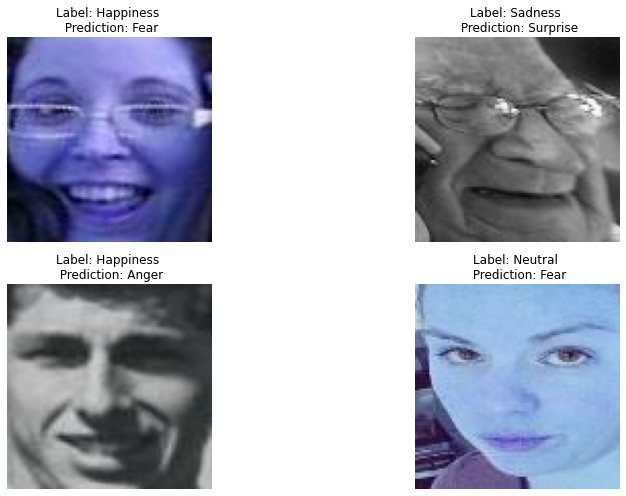

Function execution time: 0.7181222438812256 seconds


In [25]:
# Model types are: 'CNN', 'SIFTMLP' and 'SIFTSVM'
path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test')
EmotionRecognition(path_to_testset, 'SIFTSVM') 

# Test EmotionRecognitionVideo

This section should allow a quick test of the `EmotionRecognitionVideo` function. First, add cells with the code needed to load the necessary subroutines to make `EmotionRecognitionVideo` work.

Defining the function.


In [19]:
def EmotionRecognitionVideo(videoframes):
  # Writing a key to convert the labels to the corresponding emotions.
  
  keyCNN = {0:'Surprise', 1:'Fear', 2:'Disgust',3:'Happiness', 4:'Sadness', 5:'Anger', 6:'Neutral'}
  # This Cascade Classifier Code was taken from Lab 6 of the Computer Vision Module at City, University of London
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
### REFERENCE ###
  #This guide was used to help me generate random numbers: https://www.tutorialspoint.com/generating-random-number-list-in-python
  indexvalues = [] # This list will contain random indexes to access random frames of the video
  for index in range(0,4):
    index = random.randint(0, len(videoframes))
    indexvalues.append(index)
### REFERENCE ###
# The code below for facecascade was adapted from Lab_06.ipynb of the Computer Vision Module at City, University of London
  for index in indexvalues:
    image = color.rgb2gray(videoframes[index]) 
    image = img_as_ubyte(image) 
    listface = face_cascade.detectMultiScale(image, 1.3, 5) # Getting coordinates for all faces in the frame
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(videoframes[index]), ax.set_axis_off()
    for f in listface: #Looping through faces in a given frame
       
       ax.add_patch(
            patches.Rectangle(xy=(f[0], f[1]), width=f[2], height=f[3],
                          fill=False, color='r', linewidth=2)) # Adding bounding box around the face in the frame.
       fig.tight_layout
       crop = videoframes[index][f[1]:f[1]+f[3], f[0]:f[0]+f[2]] #Cropping the face, creating a new image of just the face
       crop = cv2.resize(crop,(100,100)) # Resizing the cropped face for compatibility with CNN
       crop = crop.reshape(3,100,100) # Reshaping the cropped face for compatibility with CNN
       crop = np.array(crop,dtype=np.float32)
       keyCNN = {0:'Surprise', 1:'Fear', 2:'Disgust',3:'Happiness', 4:'Sadness', 5:'Anger', 6:'Neutral'}
       y_pred = CNN.predict(crop) # Predicting label of the face.
       y_pred = keyCNN[int(y_pred)] # Converting label to corresponding string emotion
       plt.annotate(y_pred, (f[0], f[1]+ f[3]+40), color = 'r') # annotating bounding box with the emotion
  plt.show()


Loading the video and extracting the frames.

In [15]:
%matplotlib inline
### REFERENCE ###
# The code for extracting the video frames was adapted from Lab_05.ipynb of the Computer Vision Module at City, University of London
cap = cv2.VideoCapture(os.path.join(GOOGLE_DRIVE_PATH, 'Video', 'videoplayback.mp4'))
fW = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fC = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fH = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

video = np.empty((fC, fH, fW, 3), np.dtype('uint8'))


truth = True
framec = 0

while framec < fC and truth:
    ret, video[framec] = cap.read()
    video[framec] = cv2.cvtColor(video[framec], cv2.COLOR_BGR2RGB)
    framec += 1

cap.release()

Then, make a call to the `EmotionRecognitionVideo` function to see what results it produces.

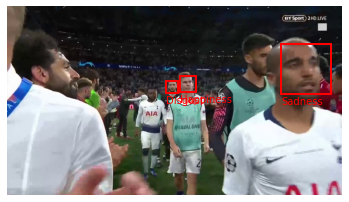

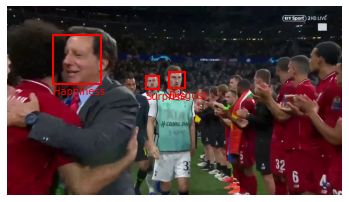

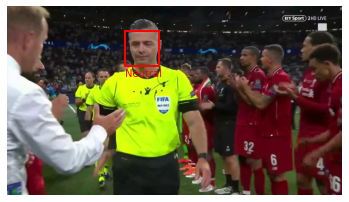

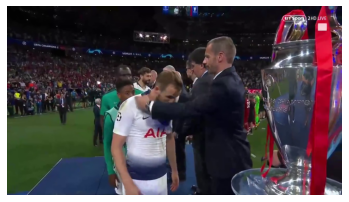

In [27]:
EmotionRecognitionVideo(video)
# Note: the facial recognition algorithm doesn't always identify all faces in the frame.